# Setup

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import einops
import matplotlib
from functools import partial
from collections import namedtuple
import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, grad, jit
import jax.debug
import itertools
from itertools import repeat
from time import time

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# Dask

In [51]:

# https://docs.dask.org/en/stable/deploying-python.html

import jax
import os
import dask
from dask.distributed import Client, LocalCluster

cpu_device, *_ = jax.devices("cpu")
cpu_count = os.cpu_count()
print('cpu count = ', cpu_count)
#client = Client(n_workers=cpu_count-1) #  start local workers as processes
#client = Client(n_workers=cpu_count-1, processes=False)  # start local workers as threads

cluster = LocalCluster(n_workers=cpu_count-1)
client = Client(cluster)

print(cluster.dashboard_link)
client




cpu count =  96


/home/kpmurphy/.local/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34685 instead
  warnings.warn(


http://127.0.0.1:34685/status


ImportError: Dask diagnostics requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[diagnostics]" --upgrade  # or python -m pip install

<Client: 'tcp://127.0.0.1:42339' processes=95 threads=190, memory=334.56 GiB>

In [15]:
# # https://docs.dask.org/en/stable/futures.html

def parallel_map(f, args):
    #args = jax.device_put(args, cpu_device)
    init_time = time()
    res_lazy = client.map(f, args)
    out = client.gather(res_lazy)
    end_time = time()
    return out, end_time - init_time


def serial_map(f, args):   
    init_time = time()
    out = [f(a) for a in args]
    end_time = time()
    return out, end_time - init_time

10
[(1, 0, 100), (1, 1, 100), (1, 2, 100), (1, 3, 100), (1, 4, 100), (2, 0, 100), (2, 1, 100), (2, 2, 100), (2, 3, 100), (2, 4, 100)]


In [46]:
def f(arg):
    return f2(arg[0], arg[1], arg[2])

@partial(jit, static_argnames=["N"])
def f2(seed, x, N):
    key = jr.PRNGKey(seed)
    mat = jr.normal(key, (N, N))
    w, v = jnp.linalg.eigh(mat * jnp.transpose(mat) * x)
    return w[0]


def make_arg_combo(*args):
    iter = itertools.product(*args)
    combo = list(iter)
    #return jnp.array(combo) # one row per combo
    return combo


seeds = np.array([1, 2])   
xs = np.arange(0, 5) 
N = np.array([200]) # must be np not jnp so static_argnames=N works 
args = make_arg_combo(seeds, xs, N)

print(len(args))
print(args)

out_serial, time_serial = serial_map(f, args)
print(out_serial)
out_parallel, time_parallel = parallel_map(f, args)
assert jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel))

print('DASK time serial', time_serial, ' parallel ', time_parallel)

10
[(1, 0, 200), (1, 1, 200), (1, 2, 200), (1, 3, 200), (1, 4, 200), (2, 0, 200), (2, 1, 200), (2, 2, 200), (2, 3, 200), (2, 4, 200)]
[DeviceArray(0., dtype=float32), DeviceArray(-27.83307, dtype=float32), DeviceArray(-55.66614, dtype=float32), DeviceArray(-83.49914, dtype=float32), DeviceArray(-111.33228, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(-27.18652, dtype=float32), DeviceArray(-54.37304, dtype=float32), DeviceArray(-81.55958, dtype=float32), DeviceArray(-108.74608, dtype=float32)]
DASK time serial 0.8036661148071289  parallel  0.3853721618652344


In [42]:
# Scaling laws
rep_list = [10, 50, 100, 200]
problem_size_list = [100, 200, 500, 1000]

nreps = len(rep_list)
nsizes = len(problem_size_list)
times_serial = np.zeros((nreps, nsizes))
times_parallel = np.zeros((nreps, nsizes))

for i, nrep in enumerate(rep_list):
    seeds = np.array([1, 2, 3]) 
    xs = np.arange(1, nrep+1) 
    for j, problem_size in enumerate(problem_size_list):
        N = np.array([problem_size])
        args = make_arg_combo(seeds, xs, N)
  
        out_serial, time_serial = serial_map(f, args)
        out_parallel, time_parallel = parallel_map(f, args)
        assert jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel), atol=1e-3)
        print('nrep {}, size {}, time parallel {}, serial {}'.format(
                nrep, problem_size, time_parallel,  time_serial))
        times_serial[i,j] = time_serial
        times_parallel[i,j] = time_parallel


nrep 10, size 100, time parallel 0.23430919647216797, serial 0.009214401245117188
nrep 10, size 200, time parallel 0.24434995651245117, serial 0.0042726993560791016
nrep 10, size 500, time parallel 0.4765307903289795, serial 0.005064725875854492
nrep 10, size 1000, time parallel 0.9019978046417236, serial 22.3023738861084
nrep 50, size 100, time parallel 0.38846850395202637, serial 0.10059165954589844
nrep 50, size 200, time parallel 0.748744010925293, serial 0.3689768314361572
nrep 50, size 500, time parallel 0.5710182189941406, serial 1.9782061576843262
nrep 50, size 1000, time parallel 1.776129961013794, serial 9.439998388290405
nrep 100, size 100, time parallel 0.8533318042755127, serial 0.22597980499267578
nrep 100, size 200, time parallel 2.359445810317993, serial 0.8304665088653564
nrep 100, size 500, time parallel 1.1733956336975098, serial 4.491016626358032
nrep 100, size 1000, time parallel 2.9910781383514404, serial 21.439111709594727
nrep 200, size 100, time parallel 0.9253

In [ ]:
print(out_serial)
print(out_parallel)
print(jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel), atol=1e-3))

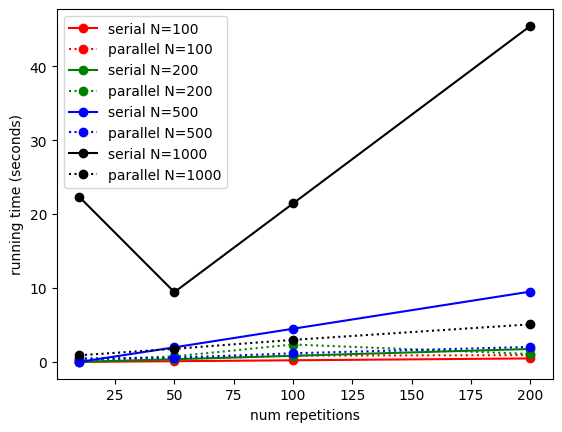

In [47]:
plt.figure()
colors = ['r', 'g', 'b', 'k', 'y']
for j, problem_size in enumerate(problem_size_list):
    plt.plot(rep_list, times_serial[:,j], linestyle = '-', marker = 'o', 
            color=colors[j], label=f'serial N={problem_size}')
    plt.plot(rep_list, times_parallel[:,j], linestyle = ':', marker = 'o', 
            color=colors[j], label=f'parallel N={problem_size}')
plt.xlabel('num repetitions')
plt.ylabel('running time (seconds)')
#plt.yscale('log')
plt.legend()

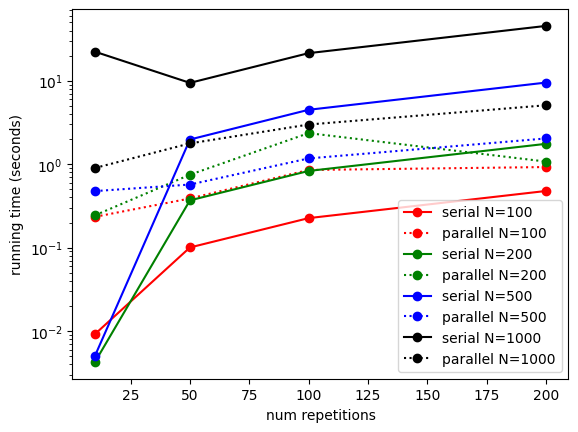

In [45]:
plt.figure()
colors = ['r', 'g', 'b', 'k', 'y']
for j, problem_size in enumerate(problem_size_list):
    plt.plot(rep_list, times_serial[:,j], linestyle = '-', marker = 'o', 
            color=colors[j], label=f'serial N={problem_size}')
    plt.plot(rep_list, times_parallel[:,j], linestyle = ':', marker = 'o', 
            color=colors[j], label=f'parallel N={problem_size}')
plt.xlabel('num repetitions')
plt.ylabel('running time (seconds)')
plt.yscale('log')
plt.legend()